In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# from matplotlib import rc
# # rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# rc('text', usetex=True)

ImportError: cannot import name 'doccer'

# $g^{(2)}(\tau)$ for a Driven Flouresing System


In [3]:
# Expectation values for a(n open) system coupled to a classical driving field. 
# Rabi oscillations are easily found. 

def Rabi(w_in,gamma_in):

    #
    # problem parameters:
    #
    delta = 0.0 * 2 * np.pi  # qubit sigma_x coefficient
    eps0 = 1.0 * 2 * np.pi   # qubit sigma_z coefficient
    A =  0.01 * 2 * np.pi     # drive amplitude (reducing -> RWA more accurate)
    w = w_in * 2 * np.pi     # drive frequency
    gamma1 = gamma_in        # relaxation rate
    n_th = 0.0               # average number of excitations ("temperature")
    psi0 = basis(2, 1)       # initial state

    #
    # Hamiltonian
    #
    sx = sigmax()
    sz = sigmaz()
    sm = destroy(2)

    H0 = - delta / 2.0 * sx - eps0 / 2.0 * sz
    H1 = - A * sx

    # define the time-dependence of the hamiltonian using the list-string format
    args = {'w': w}
    Ht = [H0, [H1, 'sin(w*t)']]

    #
    # collapse operators
    #
    c_op_list = []

    rate = gamma1 * (1 + n_th)
    if rate > 0.0:
        c_op_list.append(np.sqrt(rate) * sm)       # relaxation

    rate = gamma1 * n_th
    if rate > 0.0:
        c_op_list.append(np.sqrt(rate) * sm.dag())  # excitation

    #
    # evolve and system subject to the time-dependent hamiltonian
    #
    tlist = np.linspace(0, 5.0 * 2 * np.pi / A, 500)
    output1 = mesolve(Ht, psi0, tlist, c_op_list, [sm.dag() * sm], args)

    # Alternative: write the hamiltonian in a rotating frame, and neglect the
    # the high frequency component (rotating wave approximation), so that the
    # resulting Hamiltonian is time-independent.
    H_rwa = - delta / 2.0 * sx - A * sx / 2
    output2 = mesolve(H_rwa, psi0, tlist, c_op_list, [sm.dag() * sm])

    #
    # Plot the solution
    #
    plt.plot(tlist, np.real(output1.expect[0]), 'b', tlist, np.real(output2.expect[0]), 'r')
    plt.xlabel('Time')
    plt.ylabel('Occupation probability')
    plt.title('Excitation probabilty of qubit')
    plt.legend(("Time-dependent Hamiltonian", "Corresponding RWA"))
    plt.show()

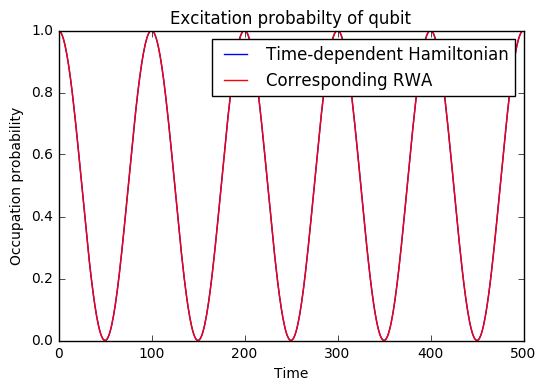

In [4]:
Rabi(1.0,.00)

# Flourescing Spins: via coupling to a quantum electromagnetic field mode

We now extend the above simulation to the case in which the two level system is (strongly) coupled to a (leaky) cavity mode. This calculation is performed in order to directly compute the $g^{(2)}(\tau)$ second-order coherence function. 

A very leaky cavity mode (loosly) models the light flouresced by quantum emitter. When in an excited state $|e\rangle$ a quantum emitter may decay to the ground state $|g \rangle$ and emit a photon at energy $\hbar \omega_{eg}$. The decay rate is a function of the number of EM modes availible coupled to the emitter and also of the coupling strength (see Purcell effect). 

Strong coupling between the spin and EM field ($A \gg \epsilon_0$) isnt motivated by true strong coupling but by the fact that a strong enhancement of the spontaneous emission rate is observed in the presence of an Ag rod.  


To calculate the second order coherence function we will initialize the system in some starting configuration (more about this later) and allow the system to evolve until it reaches a steady state (which one can physically expect). Then we use this steady state as our state at time $t$ and calculate  $g^{(2)}(\tau)$ as a function of the delay time $\tau$.

In [2]:
# define parameter, operators, and  Hamiltonian

#
# problem parameters:
#
delta = 0.0 * 2 * np.pi  # qubit sigma_x coefficient
eps0 = 1.0 * 2 * np.pi   # qubit sigma_z coefficient
A =  1.0 * 2 * np.pi     # drive amplitude (reducing -> RWA more accurate)
w =  1.0 * 2 * np.pi     # drive frequency
gamma = 0.00             # relaxation rate
n_th = 0.0               # average number of excitations ("temperature")


M = 20                    # Number of cavity modes not truncated
w_C = 1.0 * 2 * np.pi     # cavity mode level spacing
g12 = 10.0                # cavity / spin coupling strength
kappa = 0.9               # cavity relaxation rate
n_C_th = 0                # number of thermal cavity modes

#
# Hamiltonian
#

sx = tensor(sigmax(),qeye(M))
sz = tensor(sigmaz(),qeye(M))
sm = tensor(destroy(2),qeye(M))
a  = tensor(qeye(2),destroy(M))

H0   = - eps0 / 2.0 * sz + w_C / 2 * a.dag()*a
Hint = g12 / 2 * (a + a.dag()) * (sm + sm.dag())

# define the time-dependence of the hamiltonian using the list-string format
H1 = - A * sx
args = {'w': w}
Ht = [H0 + Hint, [H1, 'sin(w*t)']]

# Collapse operators
c_op_list = []

# leaky cavity 
c_op_list.append(np.sqrt(kappa * (n_C_th + 1)) * a)
c_op_list.append(np.sqrt(kappa * n_C_th) * a.dag())
# leaky spins --- dissipating into some other unknown field
# c_op_list.append(np.sqrt(gamma * (1 + n_th)) * sm)   # relaxation
# c_op_list.append(np.sqrt(gamma * n_th) * sm.dag())  # excitation



# qutip 2.0 method to find steady state -- looks good but takes long time
# U = propagator(Ht, T, c_op_list, args)
# rho_ss = propagator_steadystate(U)


# second time domain for Floquet analysis
#T = 2 * np.pi / (1 * w)


# discretized time domain
tlist_ss = np.linspace(0, 100 * 2 * np.pi / A, 1000)

#
# |y(t=0)>
# 
psi0 = tensor(basis(2,0),basis(M,0))
# psi0 = tensor(thermal_dm(2,100),outer(basis(M,0),basis(M,0)))  # initial thermal state

rho_t = mesolve(Ht, psi0, tlist_ss, c_op_list, [], args)
rho_ss = rho_t.states[len(tlist_ss)-1]

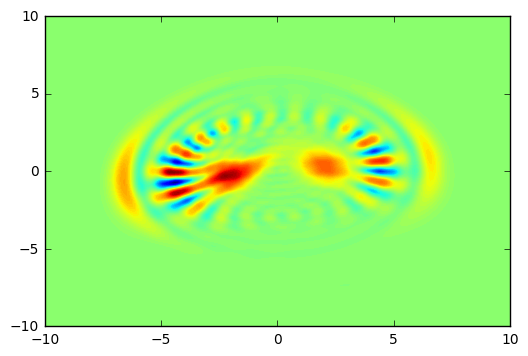

In [53]:
plt.contourf(xvec, yvec, W_t[100], 100)
plt.show()

In [90]:
import matplotlib.animation as animation
from matplotlib import animation
import types


fig = plt.figure()
# Some 2D arrays to plot (time,x,y)
data = W_t

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(len(W_t)):
    t_step = int(i)
    im = plt.contourf(W_t[i])
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, blit=False,repeat_delay=1000)
mywriter = animaion.FFMpegWriter()
ani.save('dynamic_images.mp4',writer=mywriter) 

plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'ffmpeg'

In [115]:
ani.save('dynamic_images.mp4', writer = mywriter) 


FileNotFoundError: [Errno 2] No such file or directory: 'ffmpeg'

In [46]:
xvec = np.linspace(-10,10,200)
yvec = np.linspace(-10,10,200)
W_t = [qutip.wigner(rho_t.states[iii],xvec,yvec) for iii in range(1000)]
# plt.contourf(xvec, yvec, W_t[0], 100)
# plt.show()

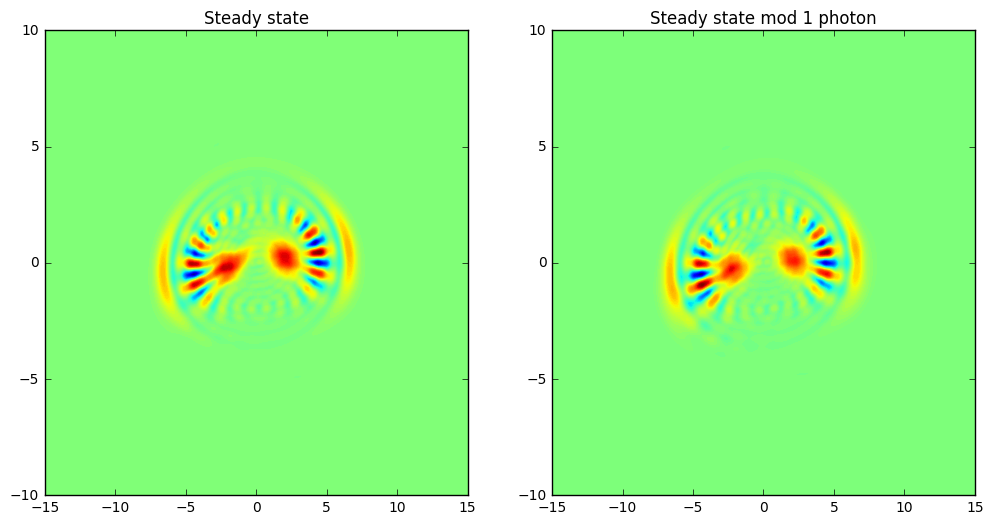

In [25]:
#
# rho(t) # call the steady state the state at time t 
# when we measure the first photon
#

rho0 = rho_ss
rho1 = a * rho0 * a.dag()  / (a * rho0 * a.dag()).tr()

xvec = np.linspace(-15,15,400)
yvec = np.linspace(-10,10,400)
W_0 = qutip.wigner(rho0,xvec,xvec)
W_1 = qutip.wigner(rho1,xvec,xvec)
# W_0 = qutip.qfunc(rho0,xvec,xvec)
# W_1 = qutip.qfunc(rho1,xvec,xvec)

fig, axes = plt.subplots(1, 2, figsize=(12,6))

cont0 = axes[0].contourf(xvec, yvec, W_0, 100)

lbl0 = axes[0].set_title("Steady state")

cont1 = axes[1].contourf(xvec, yvec, W_1, 100)

lbl1 = axes[1].set_title("Steady state mod 1 photon")
plt.show()

# plot Fock basis probability distribution function
# qutip.visualization.plot_fock_distribution(ptrace(rho0,1))
# qutip.visualization.plot_fock_distribution(ptrace(rho1,1))
# plt.show()

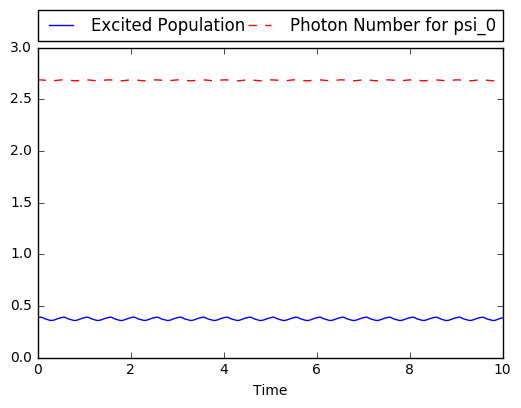

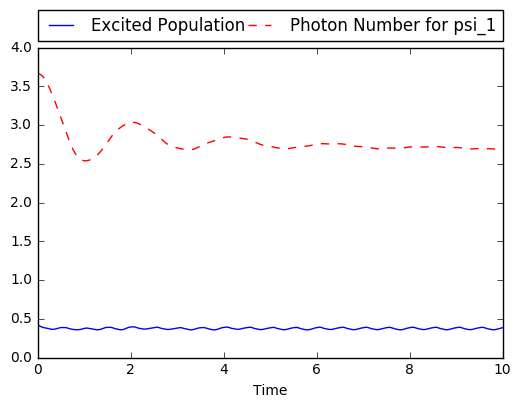

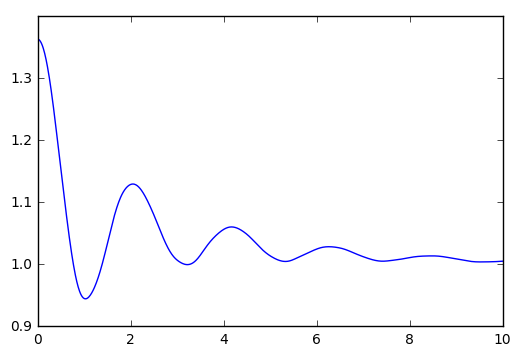

In [23]:
# discretized time domain for g_2
tlist = np.linspace(0, 10 * 2 * np.pi / A, 1000)

n_ave_0 = expect(a.dag()*a,rho0) 

output0 = mesolve(Ht, rho0, tlist, c_op_list, [sm.dag() * sm, a.dag() * a], args)
output1 = mesolve(Ht, rho1, tlist, c_op_list, [sm.dag() * sm, a.dag() * a], args)

plt.plot(tlist, output0.expect[0], 'b-')
plt.plot(tlist, output0.expect[1], 'r--')
plt.xlabel('Time')
# plt.ylabel('Occupation probability')
plt.legend(("Excited Population", "Photon Number for psi_0"),bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
plt.show()


plt.plot(tlist, output1.expect[0], 'b-')
plt.plot(tlist, output1.expect[1], 'r--')
plt.xlabel('Time')
# plt.ylabel('Occupation probability')
plt.legend(("Excited Population", "Photon Number for psi_1"),bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
plt.show()

# calculate g_2 by method detailed above
g_2 = [output1.expect[1][iii]/(output0.expect[1][iii]) for iii in range(len(tlist))]
plt.plot(tlist, g_2)
plt.show(g_2)

# Multi-Spin System

### Two spins coupled to cavity

We now (again) extend the above calculation to the case in which many two level system are (strongly) coupled to a (leaky) cavity mode.

In [13]:
#
# problem parameters:
#
delta = 0.0 * 2 * np.pi  # qubit sigma_x coefficient
eps0 = 1.0 * 2 * np.pi   # qubit sigma_z coefficient
A =  1.0 * 2 * np.pi     # drive amplitude (reducing -> RWA more accurate)
w =  1.0 * 2 * np.pi     # drive frequency
gamma = 0.00             # relaxation rate
n_th = 0.0               # average number of excitations ("temperature")


M = 20                    # Number of cavity modes not truncated
w_C = 1.0 * 2 * np.pi     # cavity mode level spacing
g12 = 10.0                # cavity / spin coupling strength
kappa = 0.5               # cavity relaxation rate
n_C_th = 0                # number of thermal cavity modes

#
# Hamiltonian
#

sx1 = tensor(sigmax(),qeye(2),qeye(M))
sz1 = tensor(sigmaz(),qeye(2),qeye(M))
sm1 = tensor(destroy(2),qeye(2),qeye(M))

sx2 = tensor(qeye(2),sigmax(),qeye(M))
sz2 = tensor(qeye(2),sigmaz(),qeye(M))
sm2 = tensor(qeye(2),destroy(2),qeye(M))
a  = tensor(qeye(2),qeye(2),destroy(M))


H0   = - eps0 / 2.0 * (sz1 + sz2) + w_C / 2 * a.dag()*a
Hint = g12 / 2 * (a + a.dag()) * (sm1 + sm1.dag() + sm2 + sm2.dag())


# define the time-dependence of the hamiltonian using the list-string format
H1 = - A * (sx1 + sx2)
args = {'w': w}
Ht = [H0 + Hint, [H1, 'sin(w*t)']]


# Collapse operators
c_op_list = []

# leaky cavity 
c_op_list.append(np.sqrt(kappa * (n_C_th + 1)) * a)
c_op_list.append(np.sqrt(kappa * n_C_th) * a.dag())
# leaky spins --- dissipating into some other unknown field
# c_op_list.append(np.sqrt(gamma * (1 + n_th)) * sm)   # relaxation
# c_op_list.append(np.sqrt(gamma * n_th) * sm.dag())  # excitation



# discretized time domain
tlist_ss = np.linspace(0, 100 * 2 * np.pi / A, 10000)

#
# |y(t=0)>
# 
psi0 = tensor(basis(2,0),basis(2,0),basis(M,1))
rho_t = mesolve(Ht, psi0, tlist_ss, c_op_list, [], args)
rho_ss = rho_t.states[len(tlist_ss)-1]


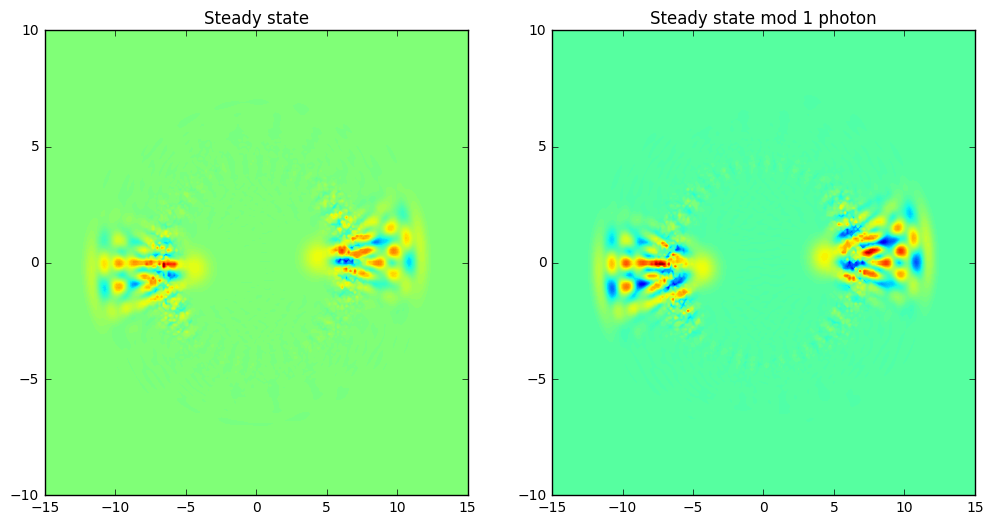

In [3]:
#
# rho(t) # call the state at final time t_F == rho_ss == rho_0
# when we measure the first photon
#

rho0 = rho_ss
rho1 = a * rho0 * a.dag()  / (a * rho0 * a.dag()).tr()

xvec = np.linspace(-15,15,200)
yvec = np.linspace(-10,10,200)
W_0 = qutip.wigner(rho0,xvec,xvec)
W_1 = qutip.wigner(rho1,xvec,xvec)
# W_0 = qutip.qfunc(rho0,xvec,xvec)
# W_1 = qutip.qfunc(rho1,xvec,xvec)

fig, axes = plt.subplots(1, 2, figsize=(12,6))

cont0 = axes[0].contourf(xvec, yvec, W_0, 100)

lbl0 = axes[0].set_title("Steady state")

cont1 = axes[1].contourf(xvec, yvec, W_1, 100)

lbl1 = axes[1].set_title("Steady state mod 1 photon")
plt.show()

# plot Fock basis probability distribution function
# qutip.visualization.plot_fock_distribution(ptrace(rho0,1))
# qutip.visualization.plot_fock_distribution(ptrace(rho1,1))
# plt.show()

In [19]:
rho0 = rho_ss
rho1 = a * rho0 * a.dag()  / (a * rho0 * a.dag()).tr()
n_ave_0 = expect(a.dag()*a,rho0) 


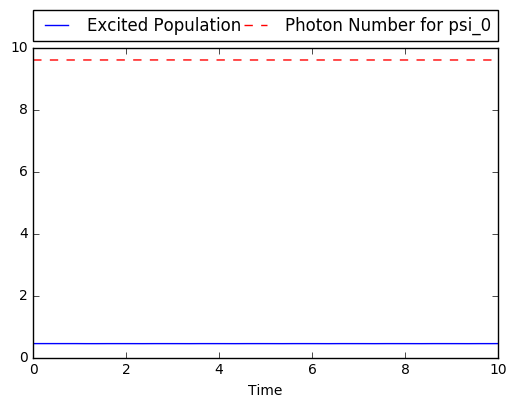

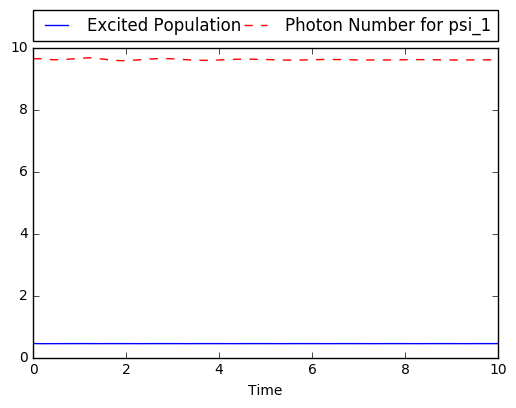

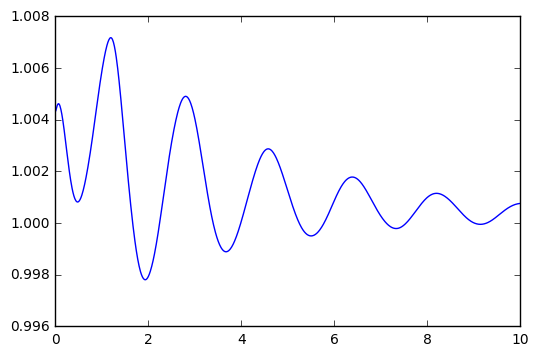

In [20]:
# discretized time domain for g_2
tlist = np.linspace(0, 10 * 2 * np.pi / A, 1000)

output0 = mesolve(Ht, rho0, tlist, c_op_list, [sm1.dag() * sm1, a.dag() * a], args)
output1 = mesolve(Ht, rho1, tlist, c_op_list, [sm1.dag() * sm1, a.dag() * a], args)

plt.plot(tlist, output0.expect[0], 'b-')
plt.plot(tlist, output0.expect[1], 'r--')
plt.xlabel('Time')
# plt.ylabel('Occupation probability')
plt.legend(("Excited Population", "Photon Number for psi_0"),bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
plt.show()


plt.plot(tlist, output1.expect[0], 'b-')
plt.plot(tlist, output1.expect[1], 'r--')
plt.xlabel('Time')
# plt.ylabel('Occupation probability')
plt.legend(("Excited Population", "Photon Number for psi_1"),bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
plt.show()

# calculate g_2 by method detailed above
g_2 = [output1.expect[1][iii]/(output0.expect[1][iii]) for iii in range(len(tlist))]
plt.plot(tlist, g_2)
plt.show(g_2)

In [ ]:

# #
# # |y(t=0)>
# # then destroy a single photon at time t=0: |y'(t=0)> = a * |y(t=0)> 
# # and normalize |y'(t=0)> = 1/normalization |y'(t=0)>
# psi0 = tensor(basis(2,1),basis(2,1),basis(M,3))
# n_ave_0 = expect(a.dag()*a,psi0) 
# omega = expect(tensor(qeye(2),qeye(2),qeye(M)),a * psi0)
# psi1 = a * psi0

# # discretized time domain
# tlist = np.linspace(0, 100 * 2 * np.pi / A, 1000000)

# #
# # |y(t=0)>
# # 
# psi0 = tensor(basis(2,0),basis(2,0),basis(M,1))

# output0 = mesolve(Ht, psi0, tlist, c_op_list, [sm1.dag() * sm1, a.dag() * a], args)
# n_ave_0 = expect(a.dag()*a,psi0) 

# #
# # then destroy a single photon at time t=0: |y'(t=0)> = a * |y(t=0)> 
# # 

# omega = expect(tensor(qeye(2),qeye(2),qeye(M)),a * psi0)
# psi1 = 1/np.sqrt(omega) * a * psi0

# output1 = mesolve(Ht, psi1, tlist, c_op_list, [sm1.dag() * sm1, a.dag() * a], args)


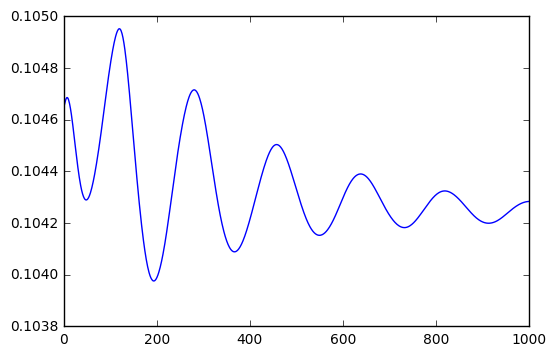

In [6]:
# plt.plot(tlist, output0.expect[0], 'b-')
# plt.plot(tlist, output0.expect[1], 'r--')
# plt.xlabel('Time')
# # plt.ylabel('Occupation probability')
# plt.legend(("Excited Population", "Photon Number"),bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#            ncol=2, mode="expand", borderaxespad=0.)
# plt.show()


# plt.plot(tlist, output1.expect[0], 'b-')
# plt.plot(tlist, output1.expect[1], 'r--')
# plt.xlabel('Time')
# # plt.ylabel('Occupation probability')
# plt.legend(("Excited Population", "Photon Number"),bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#            ncol=2, mode="expand", borderaxespad=0.)
# plt.show()

# calculate g_2 by method detailed above
g_2 = [output1.expect[1][iii]/(n_ave_0 * output0.expect[1][iii]) for iii in range(len(tlist))]
plt.plot(g_2)
plt.show(g_2)

### Three spins coupled to cavity

In [3]:
#
# problem parameters:
#
delta = 0.0 * 2 * np.pi  # qubit sigma_x coefficient
eps0 = 1.0 * 2 * np.pi   # qubit sigma_z coefficient
A =  1.0 * 2 * np.pi    # drive amplitude (reducing -> RWA more accurate)
w =  1.0 * 2 * np.pi     # drive frequency
gamma = 0.00             # relaxation rate
n_th = 0.0               # average number of excitations ("temperature")


M = 16                    # Number of cavity modes not truncated
w_C = 1.0 * 2 * np.pi     # cavity mode level spacing
g12 = 10.0                # cavity / spin coupling strength
kappa = 0.5               # cavity relaxation rate
n_C_th = 0                # number of thermal cavity modes


#
# Hamiltonian
#

sx1 = tensor(sigmax(),qeye(2),qeye(2),qeye(M))
sz1 = tensor(sigmaz(),qeye(2),qeye(2),qeye(M))
sm1 = tensor(destroy(2),qeye(2),qeye(2),qeye(M))

sx2 = tensor(qeye(2),sigmax(),qeye(2),qeye(M))
sz2 = tensor(qeye(2),sigmaz(),qeye(2),qeye(M))
sm2 = tensor(qeye(2),destroy(2),qeye(2),qeye(M))

sx3 = tensor(qeye(2),qeye(2),sigmax(),qeye(M))
sz3 = tensor(qeye(2),qeye(2),sigmaz(),qeye(M))
sm3 = tensor(qeye(2),qeye(2),destroy(2),qeye(M))
a  = tensor(qeye(2),qeye(2),qeye(2),destroy(M))


H0   = - eps0 / 2.0 * (sz1 + sz2 + sz3) + w_C / 2 * a.dag()*a
Hint = g12 / 2 * (a + a.dag()) * (sm1 + sm1.dag() + sm2 + sm2.dag() + sm3 + sm3.dag())


# define the time-dependence of the hamiltonian using the list-string format
H1 = - A * (sx1 + sx2 + sx3)
args = {'w': w}
Ht = [H0 + Hint, [H1, 'sin(w*t)']]

# Collapse operators
c_op_list = []

# leaky cavity 
c_op_list.append(np.sqrt(kappa * (n_C_th + 1)) * a)
c_op_list.append(np.sqrt(kappa * n_C_th) * a.dag())
# leaky spins --- dissipating into some other unknown field
# c_op_list.append(np.sqrt(gamma * (1 + n_th)) * sm)   # relaxation
# c_op_list.append(np.sqrt(gamma * n_th) * sm.dag())  # excitation

# discretized time domain
tlist = np.linspace(0, 100 * 2 * np.pi / A, 1000000)


#
# |y(t=0)>
# 
psi0 = tensor(basis(2,0),basis(2,0),basis(2,0),basis(M,1))

output0 = mesolve(Ht, psi0, tlist, c_op_list, [sm1.dag() * sm1, a.dag() * a], args)
n_ave_0 = expect(a.dag()*a,psi0) 

#
# then destroy a single photon at time t=0: |y'(t=0)> = a * |y(t=0)> 
# 

omega = expect(tensor(qeye(2),qeye(2),qeye(2),qeye(M)),a * psi0)
psi1 = 1/np.sqrt(omega) * a * psi0

output1 = mesolve(Ht, psi1, tlist, c_op_list, [sm1.dag() * sm1, a.dag() * a], args)


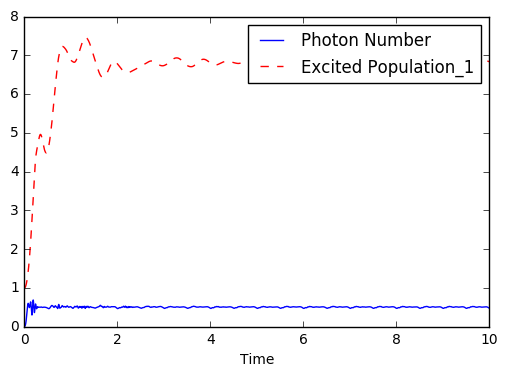

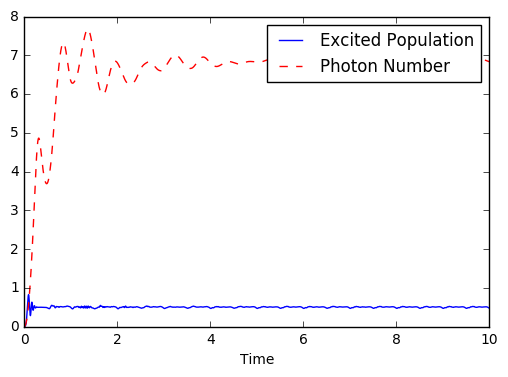

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in double_scalars


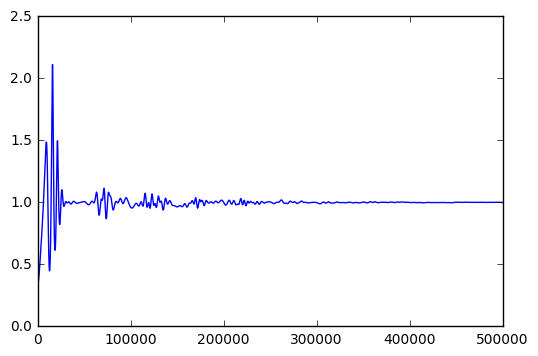

In [22]:
plt.plot(tlist, output0.expect[0], 'b-')
plt.plot(tlist, output0.expect[1], 'r--')
# plt.plot(tlist, output0.expect[2], 'g-')
# plt.plot(tlist, output0.expect[3], 'k--')
plt.xlabel('Time')
# plt.ylabel('Occupation probability')
plt.legend(("Photon Number", "Excited Population_1"),)
plt.show()


plt.plot(tlist, output1.expect[0], 'b-')
plt.plot(tlist, output1.expect[1], 'r--')
plt.xlabel('Time')
# plt.ylabel('Occupation probability')
plt.legend(("Excited Population", "Photon Number"),)
plt.show()

# calculate g_2 by method detailed above
g_2 = [output1.expect[0][iii]/(n_ave_0 * output0.expect[0][iii]) for iii in range(len(tlist))]
plt.plot(g_2[:len(g_2)//2])
plt.show()

### Generalized  N-spin system

Finally, we genearlize the above simulation to include an arbitrary number of spins. The next step, to connect with 
experiment, will be to further generalize the Hamiltonian such that the driving amplitude is spatially modulated according to the positions of the spins relative to the electron beam. 

In [82]:
#
# problem parameters:
#
N = 5                    # number of spins
delta = 0.0 * 2 * np.pi  # qubit sigma_x coefficient
eps0 = 1.0 * 2 * np.pi   # qubit sigma_z coefficient
A =  1.50 * 2 * np.pi    # drive amplitude (reducing -> RWA more accurate)
w =  1.0 * 2 * np.pi     # drive frequency
gamma = 0.00             # relaxation rate
n_th = 0.0               # average number of excitations ("temperature")


M = 20                    # Number of cavity modes not truncated
w_C = 0.5 * 2 * np.pi     # cavity mode level spacing
g12 = 0.70                # cavity / spin coupling strength
kappa = 0.02              # cavity relaxation rate
n_C_th = 5                # number of thermal cavity modes


#
# Operators
#


pre_ID = [qeye(2)] * N
pre_ID.append(qeye(M))
ID = tensor(pre_ID)

def sx(pos):
    oplist = [qeye(2)] * N
    oplist[pos] = sigmax()
    oplist.append(qeye(M))
    return tensor(oplist)

def sz(pos):
    oplist = [qeye(2)] * N
    oplist[pos] = sigmaz()
    oplist.append(qeye(M))
    return tensor(oplist)

def sm(pos):
    oplist = [qeye(2)] * N
    oplist[pos] = destroy(2)
    oplist.append(qeye(M))
    return tensor(oplist)

pre_a = [qeye(2)]*N 
pre_a.append(destroy(M))
a = tensor(pre_a)
n_a = a.dag() * a

H0 = - eps0 / 2.0 *  sum([sz(pos) for pos in range(N)]) + w_C / 2 * n_a
Hint = g12 / 2 * (a + a.dag()) * sum([sm(pos) + sm(pos).dag() for pos in range(N)])
# (sm1 + sm1.dag() + sm2 + sm2.dag() + sm3 + sm3.dag())
# define the time-dependence of the hamiltonian using the list-string format
H1 = - A * sum([sx(pos) for pos in range(N)])
args = {'w': w}
Ht = [H0 + Hint, [H1, 'sin(w*t)']]

#
# |y(t=0)>
# then destroy a single photon at time t=0: |y'(t=0)> = a * |y(t=0)> # and normalize |y'(t=0)> = 1/normalization |y'(t=0)>

pre_psi = [basis(2,0)] * N
pre_psi.append(basis(M,2))
psi0 = tensor(pre_psi)
n_ave_0 = expect(n_a,psi0) 
omega = expect(ID, a * psi0)
psi1 =  a * psi0


# Collapse operators
c_op_list = []

# leaky cavity 
c_op_list.append(np.sqrt(kappa * (n_C_th + 1)) * a)
c_op_list.append(np.sqrt(kappa * n_C_th) * a.dag())
# leaky spins --- dissipating into some other unknown field
# c_op_list.append(np.sqrt(gamma * (1 + n_th)) * sm)   # relaxation
# c_op_list.append(np.sqrt(gamma * n_th) * sm.dag())  # excitation

# discretized time domain
tlist = np.linspace(0, 40 * 2 * np.pi / A, 2000)

# expectation operators == e_ops
n_1_up = sm(1).dag() * sm(1)


output0 = mesolve(Ht, psi0, tlist, c_op_list, [n_a, n_1_up], args)
output1 = mesolve(Ht, psi1, tlist, c_op_list, [n_a], args)


KeyboardInterrupt: 

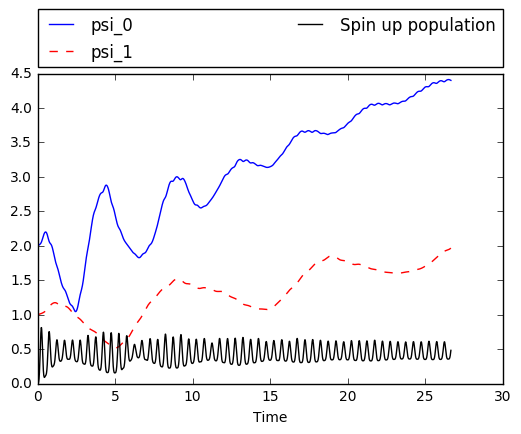

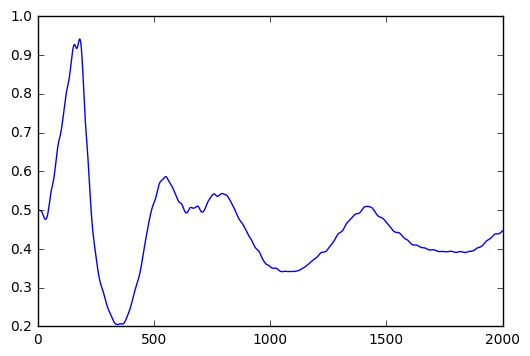

In [83]:
plt.plot(tlist, output0.expect[0], 'b-')
plt.plot(tlist, output1.expect[0]/omega, 'r--')
plt.plot(tlist, output0.expect[1], 'k-')
plt.xlabel('Time')
# plt.ylabel('Occupation probability')
plt.legend(('psi_0', "psi_1","Spin up population"),bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
plt.show()


# calculate g_2 by method detailed above
g_2 = [output1.expect[0][iii]/(n_ave_0 * output0.expect[0][iii]) for iii in range(len(tlist))]
plt.plot(g_2)
plt.show(g_2)